In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import joblib
import sys
sys.path.append("../")

from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.action_set import ActionSet
from cfmining.utils import get_data_model


%load_ext autoreload
%autoreload 2

In [2]:
def summarize_results(results, perc_calc, outlier_detection = None, outlier_percentile = 0.05, display_results = True):
    results["individual"] = results["individual"].apply(literal_eval)
    results["solutions"] = results["solutions"].apply(literal_eval)
    costs = []
    n_changes = []
    outliers = []
    outliers_score = []
    for i in range(len(results)):
        individual = results["individual"].iloc[i]
        if len(individual) == 1:
            individual = individual[0]
            
        criteria = PercentileCriterion(individual, perc_calc)
        solutions = results["solutions"].iloc[i]

        if len(solutions) == 0:
            costs.append(None)
            n_changes.append(None)
            outliers.append(None)
            outliers_score.append(None)
            continue
        costs_ = [criteria.f(s) for s in solutions][0]
        
        
        sol0 = results["solutions"].iloc[i][0]
        n_changes_ = sum([1 for i in range(len(individual)) if individual[i] != sol0[i]])

        n_changes.append(n_changes_)
        costs.append(costs_)
        if outlier_detection is not None:
            outlier_detection.percentile = outlier_percentile
            outliers_ = [outlier_detection.predict(np.array(s)[None, :]) == -1 for s in solutions][0][0]
            outliers.append(outliers_)
            outliers_score_ = np.mean([outlier_detection.score(np.array(s)[None, :]) for s in solutions])
            outliers_score.append(outliers_score_)
        else:
            outliers.append(False)
            outliers_score.append(1)
            
    results["costs"] = costs
    results["outlier"] = outliers
    results["n_changes"] = n_changes
    results["outliers_score"] = outliers_score

    if display_results:

        print(f"Time: {results['time'].mean():.3f} +- {results['time'].std():.3f}")
        print(f"Costs: {results['costs'].mean():.3f} +- {results['costs'].std():.3f}")
        print(f"Changes: {results['n_changes'].mean():.3f} +- {results['n_changes'].std():.3f}")
        print(f"Outliers: {results['outlier'].mean():.3f}")
        print(f"Outliers score: {results['outliers_score'].mean():.3f} +- {results['outliers_score'].std():.3f}")

        fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3))
        axs[0].scatter(
            results.sort_values("prob")["prob"],
            results.sort_values("prob")["time"],
        )
        axs[0].set_xlabel("Probability")
        axs[0].set_ylabel("Time (s)")

        axs[1].scatter(
            results.sort_values("prob")["prob"],
            results.sort_values("prob")["costs"],
        )
        axs[1].set_xlabel("Probability")
        axs[1].set_ylabel("Costs")

        plt.tight_layout()
        plt.show()
    else:
        return results

In [11]:
def format_df_table(df, agg_column, columns):
    df_mean = df.groupby(agg_column).agg(dict([(c, "mean") for c in columns])).reset_index().round(3)
    df_std = df.groupby(agg_column).agg(dict([(c, "std") for c in columns])).reset_index().round(3)

    for col in columns:
        df_mean[col] = df_mean[col].astype("str") + " (+-" + df_std[col].astype("str") + ")"
    return df_mean

## German

In [21]:
X_train, Y_train, model, _, _ = get_data_model("german")
outlier_detection = joblib.load("../models/german/IsolationForest_test.pkl")

In [22]:
not_mutable_features = ['Age', 'OwnsHouse', 'isMale', 'JobClassIsSkilled', 'Single', 'ForeignWorker', 'RentsHouse']
mutable_features = [feat for feat in X_train.columns if feat not in not_mutable_features]
action_set = ActionSet(X = X_train, default_step_size = 0.01, mutable_features = mutable_features)
perc_calc = PercentileCalculator(X = X_train)

### LGBM

In [23]:
paths = "../results/lgbm/german/"
methods = ["dice_1sol", "nice", "mapocam_percentile", "mapofcem_percentile", "mapofcem_v2_percentile", "mapofcem_no_outlier_percentile"]

results = []
for m in methods:
    results_saved = pd.read_csv(f"{paths}{m}.csv")
    results.append(summarize_results(results_saved, perc_calc, outlier_detection, display_results = False))
    results[-1]["method"] = m
results = pd.concat(results)

print(paths)
format_df_table(
    results, "method", ["time", "costs", "n_changes", "outlier", "outliers_score"]
)

../results/lgbm/german/


,method,time,costs,n_changes,outlier,outliers_score
0,dice_1sol,0.161 (+-0.008),0.494 (+-0.264),1.68 (+-0.471),0.08 (+-0.274),0.496 (+-0.049)
1,mapocam_percentile,0.458 (+-1.252),0.065 (+-0.041),2.14 (+-0.881),0.22 (+-0.418),0.521 (+-0.05)
2,mapofcem_no_outlier_percentile,0.209 (+-0.328),0.081 (+-0.08),2.06 (+-0.767),0.2 (+-0.404),0.519 (+-0.048)
3,mapofcem_percentile,0.311 (+-0.608),0.098 (+-0.1),2.06 (+-0.89),0.06 (+-0.24),0.507 (+-0.036)
4,mapofcem_v2_percentile,0.337 (+-0.634),0.098 (+-0.1),2.06 (+-0.89),0.06 (+-0.24),0.507 (+-0.036)
5,nice,0.005 (+-0.002),0.395 (+-0.264),1.46 (+-0.706),0.12 (+-0.328),0.481 (+-0.05)


### MLP

In [24]:
paths = "../results/mlp/german/"
methods = ["dice_1sol", "nice", "mapocam_percentile", "mapofcem_percentile", "mapofcem_perm_percentile"]

results = []
for m in methods:
    results_saved = pd.read_csv(f"{paths}{m}.csv")
    results.append(summarize_results(results_saved, perc_calc, outlier_detection, display_results = False))
    results[-1]["method"] = m
results = pd.concat(results)

print(paths)
format_df_table(
    results, "method", ["time", "costs", "n_changes", "outlier", "outliers_score"]
)

../results/mlp/german/


,method,time,costs,n_changes,outlier,outliers_score
0,dice_1sol,0.17 (+-0.026),0.417 (+-0.276),1.92 (+-0.634),0.24 (+-0.431),0.518 (+-0.057)
1,mapocam_percentile,1.488 (+-6.463),0.082 (+-0.123),2.04 (+-0.925),0.24 (+-0.431),0.523 (+-0.046)
2,mapofcem_percentile,0.378 (+-0.646),0.082 (+-0.085),1.729 (+-0.792),0.125 (+-0.357),0.513 (+-0.038)
3,mapofcem_perm_percentile,0.84 (+-1.639),0.083 (+-0.086),1.75 (+-0.786),0.125 (+-0.357),0.513 (+-0.037)
4,nice,0.005 (+-0.003),0.486 (+-0.247),2.12 (+-1.56),0.04 (+-0.198),0.466 (+-0.051)


### Percentile of outliers

In [32]:
paths = "../results/german/"


results = []
for method_name in ["mapofcem_percentile_outlier_", "mapofcem_v2_percentile_outlier_"]:
    for outlier_percentile in [0.005, 0.01, 0.05, 0.075, 0.1]:
        m = method_name + str(outlier_percentile)
        results_saved = pd.read_csv(f"{paths}{m}.csv")
        results.append(summarize_results(results_saved, perc_calc, outlier_detection, outlier_percentile, display_results = False))
        results[-1]["method"] = m
results = pd.concat(results)
results["outlier_percentile"] = results["method"].apply(lambda x: float(x.split("_")[-1]))

format_df_table(
    results, "method", ["time", "costs", "n_changes", "outlier", "outliers_score", "outlier_percentile"]
)

,method,time,costs,n_changes,outlier,outliers_score,outlier_percentile
0,mapofcem_percentile_outlier_0.005,0.486 (+-0.881),0.1 (+-0.079),2.04 (+-0.88),0.0 (+-0.0),0.505 (+-0.049),0.005 (+-0.0)
1,mapofcem_percentile_outlier_0.01,0.49 (+-0.883),0.102 (+-0.079),2.04 (+-0.903),0.02 (+-0.141),0.504 (+-0.047),0.01 (+-0.0)
2,mapofcem_percentile_outlier_0.05,0.766 (+-2.051),0.106 (+-0.079),1.959 (+-0.865),0.041 (+-0.2),0.495 (+-0.038),0.05 (+-0.0)
3,mapofcem_percentile_outlier_0.075,0.997 (+-2.455),0.11 (+-0.086),1.979 (+-0.872),0.043 (+-0.204),0.493 (+-0.037),0.075 (+-0.0)
4,mapofcem_percentile_outlier_0.1,1.046 (+-2.444),0.108 (+-0.082),1.957 (+-0.868),0.087 (+-0.285),0.488 (+-0.037),0.1 (+-0.0)
5,mapofcem_v2_percentile_outlier_0.005,0.699 (+-1.21),0.1 (+-0.079),2.04 (+-0.88),0.0 (+-0.0),0.505 (+-0.049),0.005 (+-0.0)
6,mapofcem_v2_percentile_outlier_0.01,0.701 (+-1.208),0.102 (+-0.079),2.04 (+-0.903),0.02 (+-0.141),0.504 (+-0.047),0.01 (+-0.0)
7,mapofcem_v2_percentile_outlier_0.05,1.072 (+-2.765),0.106 (+-0.079),1.959 (+-0.865),0.041 (+-0.2),0.495 (+-0.038),0.05 (+-0.0)
8,mapofcem_v2_percentile_outlier_0.075,1.359 (+-3.252),0.11 (+-0.086),1.979 (+-0.872),0.043 (+-0.204),0.493 (+-0.037),0.075 (+-0.0)
9,mapofcem_v2_percentile_outlier_0.1,1.459 (+-3.258),0.108 (+-0.082),1.957 (+-0.868),0.087 (+-0.285),0.488 (+-0.037),0.1 (+-0.0)


## Taiwan

In [25]:
X_train, Y_train, model, _, individuals = get_data_model("taiwan")
X_train = X_train.astype(int)
individuals = individuals.astype(int)
outlier_detection = joblib.load("../models/taiwan/IsolationForest_test.pkl")
outlier_detection.percentile = 0.01

In [26]:
not_mutable_features = ['Single', 'Age_in_25_to_40', 'Married', 'Age_lt_25', 'Age_in_40_to_59', 'Age_geq_60', 'EducationLevel']
mutable_features = [feat for feat in X_train.columns if feat not in not_mutable_features]
action_set = ActionSet(X = X_train, default_step_size = 0.01, mutable_features = mutable_features)
perc_calc = PercentileCalculator(X = X_train)

### LGBM

In [27]:
paths = "../results/lgbm/taiwan/"
methods = ["dice_1sol", "nice", "mapocam_percentile", "mapofcem_percentile", "mapofcem_v2_percentile", "mapofcem_no_outlier_percentile"]

results = []
for m in methods:
    results_saved = pd.read_csv(f"{paths}{m}.csv")
    results.append(summarize_results(results_saved, perc_calc, outlier_detection, display_results = False))
    results[-1]["method"] = m
results = pd.concat(results)

print(paths)
format_df_table(
    results, "method", ["time", "costs", "n_changes", "outlier", "outliers_score"]
)

../results/lgbm/taiwan/


,method,time,costs,n_changes,outlier,outliers_score
0,dice_1sol,0.235 (+-0.006),0.658 (+-0.246),1.6 (+-0.495),0.12 (+-0.328),0.498 (+-0.048)
1,mapocam_percentile,2.004 (+-4.424),0.091 (+-0.08),2.32 (+-0.891),0.06 (+-0.24),0.454 (+-0.053)
2,mapofcem_no_outlier_percentile,0.517 (+-0.768),0.093 (+-0.095),2.204 (+-0.841),0.02 (+-0.242),0.454 (+-0.052)
3,mapofcem_percentile,8.712 (+-59.151),0.116 (+-0.128),2.06 (+-0.818),0.06 (+-0.24),0.452 (+-0.05)
4,mapofcem_v2_percentile,3.685 (+-23.709),0.116 (+-0.128),2.08 (+-0.829),0.06 (+-0.24),0.452 (+-0.05)
5,nice,0.018 (+-0.005),0.246 (+-0.196),2.18 (+-1.587),0.06 (+-0.24),0.457 (+-0.055)


### MLP

In [28]:
paths = "../results/mlp/taiwan/"
methods = ["dice_1sol", "nice", "mapocam_percentile", "mapofcem_percentile", "mapofcem_perm_percentile"]

results = []
for m in methods:
    results_saved = pd.read_csv(f"{paths}{m}.csv")
    results.append(summarize_results(results_saved, perc_calc, outlier_detection, 0.01, display_results = False))
    results[-1]["method"] = m
results = pd.concat(results)

print(paths)
format_df_table(
    results, "method", ["time", "costs", "n_changes", "outlier", "outliers_score"]
)

../results/mlp/taiwan/


,method,time,costs,n_changes,outlier,outliers_score
0,dice_1sol,0.262 (+-0.14),0.694 (+-0.22),1.5 (+-0.505),0.0 (+-0.0),0.483 (+-0.039)
1,mapocam_percentile,32.215 (+-71.263),0.31 (+-0.235),2.88 (+-0.385),0.0 (+-0.0),0.442 (+-0.038)
2,mapofcem_percentile,24.558 (+-34.71),0.31 (+-0.235),2.92 (+-0.274),0.0 (+-0.0),0.44 (+-0.039)
3,mapofcem_perm_percentile,33.864 (+-36.72),0.311 (+-0.236),2.9 (+-0.303),0.0 (+-0.0),0.442 (+-0.038)
4,nice,0.02 (+-0.006),0.521 (+-0.241),5.86 (+-3.363),0.0 (+-0.0),0.438 (+-0.035)


### Percentile of outliers

In [35]:
paths = "../results/taiwan/"


results = []
for method_name in ["mapofcem_percentile_outlier_", "mapofcem_v2_percentile_outlier_"]:
    for outlier_percentile in [0.005, 0.01, 0.05, 0.075, 0.1]:
        m = method_name + str(outlier_percentile)
        results_saved = pd.read_csv(f"{paths}{m}.csv")
        results.append(summarize_results(results_saved, perc_calc, outlier_detection, outlier_percentile, display_results = False))
        results[-1]["method"] = m
results = pd.concat(results)
results["outlier_percentile"] = results["method"].apply(lambda x: float(x.split("_")[-1]))

format_df_table(
    results, "method", ["time", "costs", "n_changes", "outlier", "outliers_score", "outlier_percentile"]
)

,method,time,costs,n_changes,outlier,outliers_score,outlier_percentile
0,mapofcem_percentile_outlier_0.005,1.185 (+-3.38),0.094 (+-0.109),2.14 (+-0.948),0.0 (+-0.0),0.463 (+-0.053),0.005 (+-0.0)
1,mapofcem_percentile_outlier_0.01,1.181 (+-3.422),0.094 (+-0.109),2.14 (+-0.948),0.0 (+-0.0),0.463 (+-0.053),0.01 (+-0.0)
2,mapofcem_percentile_outlier_0.05,13.434 (+-57.116),0.099 (+-0.11),2.25 (+-0.934),0.021 (+-0.144),0.455 (+-0.04),0.05 (+-0.0)
3,mapofcem_percentile_outlier_0.075,18.094 (+-60.22),0.117 (+-0.125),2.319 (+-0.911),0.064 (+-0.247),0.452 (+-0.034),0.075 (+-0.0)
4,mapofcem_percentile_outlier_0.1,29.557 (+-83.208),0.151 (+-0.199),2.319 (+-0.911),0.085 (+-0.282),0.45 (+-0.031),0.1 (+-0.0)
5,mapofcem_v2_percentile_outlier_0.005,1.353 (+-3.664),0.094 (+-0.109),2.14 (+-0.948),0.0 (+-0.0),0.463 (+-0.053),0.005 (+-0.0)
6,mapofcem_v2_percentile_outlier_0.01,1.324 (+-3.574),0.094 (+-0.109),2.14 (+-0.948),0.0 (+-0.0),0.463 (+-0.053),0.01 (+-0.0)
7,mapofcem_v2_percentile_outlier_0.05,14.319 (+-60.077),0.099 (+-0.11),2.25 (+-0.934),0.021 (+-0.144),0.455 (+-0.04),0.05 (+-0.0)
8,mapofcem_v2_percentile_outlier_0.075,19.357 (+-63.514),0.117 (+-0.125),2.319 (+-0.911),0.064 (+-0.247),0.452 (+-0.034),0.075 (+-0.0)
9,mapofcem_v2_percentile_outlier_0.1,31.551 (+-88.329),0.151 (+-0.199),2.319 (+-0.911),0.085 (+-0.282),0.45 (+-0.031),0.1 (+-0.0)


## Step size analysis

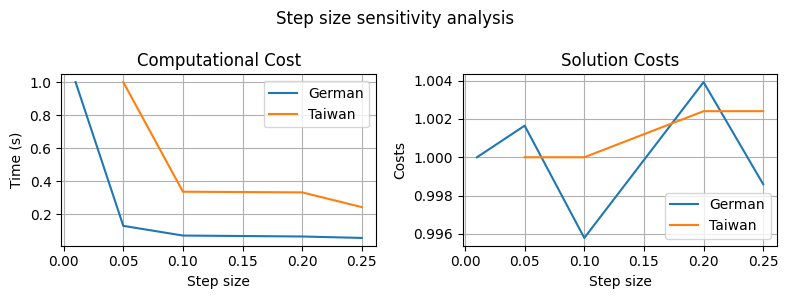

In [33]:
fig, axs  = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 3))

results_dict = []
for s in [1, 5, 10, 20, 25]:
    results = pd.read_csv(f"../results/german_step_size/mapofcem_{s}.csv")
    results = summarize_results(results, display_results=False)

    new_row = {}
    new_row["step_size"] = s/100
    new_row["time"] = results["time"].mean()
    new_row["time_std"] = results["time"].std()
    new_row["costs"] = results["costs"].mean()
    new_row["costs_std"] = results["costs"].std()
    results_dict.append(new_row)

results_dict = pd.DataFrame(results_dict)


# axs[0].fill_between(
#     results_dict["step_size"],
#     (results_dict["time"] - results_dict["time_std"]) / results_dict.time.iloc[0],
#     (results_dict["time"] + results_dict["time_std"]) / results_dict.time.iloc[0],
#     alpha = 0.3,
# )
axs[0].plot(results_dict["step_size"], results_dict["time"] / results_dict.time.iloc[0], label = "German")
axs[0].set_xlabel("Step size")
axs[0].set_ylabel("Time (s)")
#axs[0].set_yscale("log")

# axs[1].fill_between(
#     results_dict["step_size"],
#     (results_dict["costs"] - results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     (results_dict["costs"] + results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     alpha = 0.3,
# )
axs[1].plot(results_dict["step_size"], results_dict["costs"] / results_dict.costs.iloc[0], label = "German")
axs[1].set_xlabel("Step size")
axs[1].set_ylabel("Costs")


results_dict = []
for s in [5, 10, 20, 25]:
    results = pd.read_csv(f"../results/taiwan_step_size/mapofcem_{s}.csv")
    results = summarize_results(results, display_results=False)

    new_row = {}
    new_row["step_size"] = s/100
    new_row["time"] = results["time"].mean()
    new_row["time_std"] = results["time"].std()
    new_row["costs"] = results["costs"].mean()
    new_row["costs_std"] = results["costs"].std()
    results_dict.append(new_row)

results_dict = pd.DataFrame(results_dict)


# axs[0].fill_between(
#     results_dict["step_size"],
#     (results_dict["time"] - results_dict["time_std"]) / results_dict.time.iloc[0],
#     (results_dict["time"] + results_dict["time_std"]) / results_dict.time.iloc[0],
#     alpha = 0.3,
# )
axs[0].plot(results_dict["step_size"], results_dict["time"] / results_dict.time.iloc[0], label = "Taiwan")
axs[0].set_xlabel("Step size")
axs[0].set_ylabel("Time (s)")
#axs[0].set_yscale("log")

# axs[1].fill_between(
#     results_dict["step_size"],
#     (results_dict["costs"] - results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     (results_dict["costs"] + results_dict["costs_std"]) / results_dict.costs.iloc[0],
#     alpha = 0.3,
# )
axs[1].plot(results_dict["step_size"], results_dict["costs"] / results_dict.costs.iloc[0], label = "Taiwan")
axs[1].set_xlabel("Step size")
axs[1].set_ylabel("Costs")


for i in range(2):
    axs[i].legend()
    axs[i].grid()

axs[0].set_title("Computational Cost")
axs[1].set_title("Solution Costs")

plt.suptitle("Step size sensitivity analysis")
plt.tight_layout()
plt.show()